Tutorial - Part #2 - Spatially variant PSF
=======================


In [7]:
import numpy as np
import matplotlib.pyplot as plt

from properimage import single_image as s

%matplotlib inline

In [2]:
import os
import shlex
import subprocess
import sys

import numpy as np
import matplotlib.pyplot as plt


from properimage.tests import simtools
from properimage import propercoadd as pc
from properimage import single_image as si
from properimage import utils
from properimage import plot

In [3]:
# =============================================================================
#     PSF measure test by propercoadd
# =============================================================================

frames = []
for theta in [0, 45, 105, 150]:
    N = 512  # side
    X_FWHM = 5 + 2.5*theta/180
    Y_FWHM = 5
    t_exp = 1
    max_fw = max(X_FWHM, Y_FWHM)
    #test_dir = os.path.abspath('./test/test_images/psf_basis_kl_gs')

    x = np.random.randint(low=6*max_fw, high=N-6*max_fw, size=80)
    y = np.random.randint(low=6*max_fw, high=N-6*max_fw, size=80)
    xy = [(x[i], y[i]) for i in range(80)]

    SN =  5. # SN para poder medir psf
    weights = list(np.linspace(10, 1000., len(xy)))
    m = simtools.delta_point(N, center=False, xy=xy, weights=weights)
    im = simtools.image(m, N, t_exp, X_FWHM, Y_FWHM=Y_FWHM, theta=theta,
                        SN=SN, bkg_pdf='poisson')
    frames.append(im+100.)

mean = 9.1350412294, b = 45.675206147, SN = 5.0
mean = 5.95707109075, b = 29.7853554538, SN = 5.0
mean = 5.35117733197, b = 26.7558866598, SN = 5.0
mean = 4.79191989442, b = 23.9595994721, SN = 5.0


In [4]:
frame = np.zeros((1024, 1024))
for j in range(2):
    for i in range(2):
        frame[i*512:(i+1)*512, j*512:(j+1)*512] = frames[i+2*j]

In [5]:
with si.SingleImage(frame) as sim:
    a_fields, psf_basis = sim.get_variable_psf(inf_loss=0.025)
    x, y = sim.get_afield_domain()

Sources found = 47
stamps will be 9 x 9
('Masked pixels: ', 0)
cleaning... 


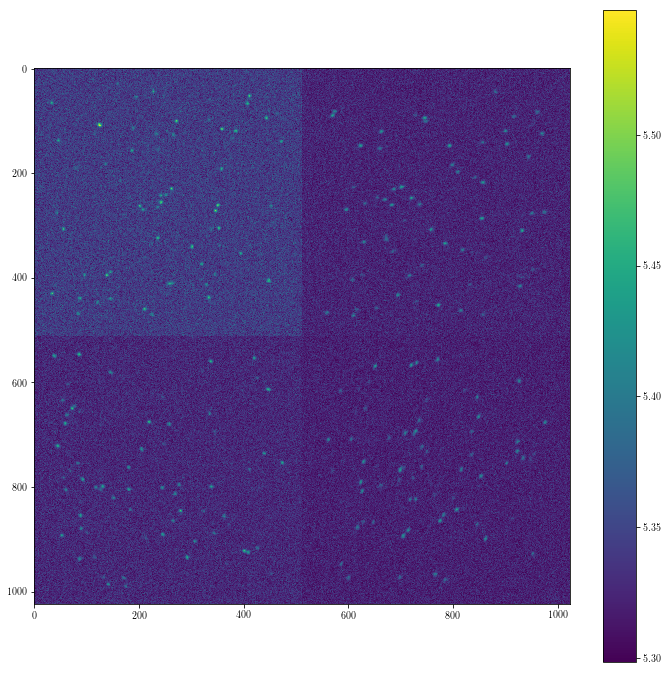

In [9]:
plt.figure(figsize=(12, 12))
plt.imshow(np.log(frame), interpolation='none')
plt.colorbar()
#plt.savefig(os.path.join(test_dir, 'test_frame.png'))
#plt.close()

#plot.plot_psfbasis(psf_basis, path=os.path.join(test_dir, 'psf_basis.png'))
#plot.plot_afields(a_fields, x, y, path=os.path.join(test_dir, 'a_fields.png'))